<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/PhysionetChallenge2012_mlp_AAAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torch
! pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [ ]:
%load_ext tensorboard

In [5]:
# %%
# Imports
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.funcs as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, \
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])
import os
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#%%
# Define classic MLP architecture
def MLP_model(input_dim, objective='svm', reg=0.01):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(
            units=128, kernel_initializer='uniform', activation='relu',
            input_dim=input_dim
    ))
    model.add(tf.keras.layers.Dense(
            units=64, kernel_initializer='uniform', activation='relu'
    ))
    if objective == 'svm':
        model.add(tf.keras.layers.Dense(
            units=1, kernel_initializer='uniform', activation='linear', kernel_regularizer=tf.keras.regularizers.l2(reg)
        ))
    elif objective == 'softmax':
        model.add(tf.keras.layers.Dense(
            units=1, kernel_initializer='uniform', activation='sigmoid'
        ))
    return model

In [7]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False), rho_grid=[0.1, 0.15])
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [8]:
#%%
# Initialize model
def init_model(input_dim, objective):
    model = MLP_model(input_dim=input_dim, objective=objective)
    if objective=='svm':
        loss = tf.keras.losses.hinge
        metric = ['hinge']

    elif objective=='softmax':
        loss = tf.keras.losses.binary_crossentropy
        metric = ['accuracy']

    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metric)
    # model.summary()
    print('loss={}'.format(loss.__name__))
    return model

In [9]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X, objective):
    if objective=='svm':
        y_pred_soft = model.predict(X)
        y_pred_th = np.array([1 if i[0] >= 0 else 0 for i in y_pred_soft])
    elif objective=='softmax':
        y_pred_soft = model.predict(X)
        y_pred_th = np.array([1 if i[0] > 0.5 else 0 for i in y_pred_soft])
    return y_pred_soft, y_pred_th

In [10]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [11]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val, rho_grid=[0.1, 0.15])
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [24]:
# For reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 123
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [25]:
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data
# -------------
df = pd.read_csv('https://raw.githubusercontent.com/ckbjimmy/2018_mlw/master/data/PhysionetChallenge2012_data.csv')
Data_X = df.iloc[:, 1:].values
Data_y = df.iloc[:, 0].values


In [26]:
#%%
# Assign labels
report_table = []
report_criteria = []
report_plot = []
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=321)
clf = 'softmax'
addPredictions = True

for sample, test in kf.split(Data_X, Data_y):
# for sample, test in kf.split(Data_X):
    X = Data_X[sample]
    y = Data_y[sample]
    imputeX = impute.SimpleImputer(missing_values=np.nan, strategy='mean').fit(X)
    X = imputeX.transform(X)
    scaleX = preprocessing.StandardScaler().fit(X)
    X = scaleX.transform(X)
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=SEED)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1], objective=clf)
    model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=0, validation_data=(X_val, y_val))
    X_test = scaleX.transform(imputeX.transform(X_test))

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train, clf)
    print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val, clf)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test, clf)

    X_train_GP = X_train
    X_val_GP = X_val
    X_test_GP = X_test
    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)
    
    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP, y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th)
    report_table.append(table)
    # Baseline for comparison
    crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    report_criteria.append(crit_table)
    del(model)

loss=binary_crossentropy
accuracy(Train)=0.905859375
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.055  noise: 0.030
Iter 492/500 - Loss: 0.055  noise: 0.030
Iter 493/500 - Loss: 0.056  noise: 0.030
Iter 494/500 - Loss: 0.057  noise: 0.030
Iter 495/500 - Loss: 0.056  noise: 0.030
Iter 496/500 - Loss: 0.055  noise: 0.030
Iter 497/500 - Loss: 0.055  noise: 0.030
Iter 498/500 - Loss: 0.054  noise: 0.030
Iter 499/500 - Loss: 0.053  noise: 0.030
Iter 500/500 - Loss: 0.057  noise: 0.030
evaluating with cuda...
evaluating with cuda...
[0, 1]
[0, 1]
2
loss=binary_crossentropy
accuracy(Train)=0.91484375
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.017  noise: 0.029
Iter 492/500 - Loss: 0.018  noise: 0.029
Iter 493/500 - Loss: 0.020  noise: 0.028
Iter 494/500 - Loss: 0.018  noise: 0.028
Iter 495/500 - Loss: 0.018  noise: 0.028
Iter 496/500 - Loss: 0.018  noise: 0.028
Iter 497/500 - Loss: 0.017  noise: 0.028
Iter 498/500 - Loss: 0.016  noise: 0.028

In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [27]:
report_table_concat = pd.concat(report_table)
# report_table_concat
report_criteria_concat = pd.concat(report_criteria)
# report_criteria_concat

# p-value column
p_value_col = report_table_concat['p_value'] #Add
cols_CQT = ['rho_user','corrected_test','queries_test','total_wrong_test','loss_query_test']
cols_rholoss = ['rho_user','rho_hat_test','%loss_red_test']

# Dataframes for f(x)
df_fx_CQT = pd.DataFrame(report_table_concat[cols_CQT])
df_fx_rholoss = pd.DataFrame(report_table_concat[cols_rholoss])
# results_fx_CQT = df_fx_CQT.loc[p_value_col <= 0.05].copy()
results_fx_rholoss = df_fx_rholoss.loc[p_value_col <= 0.05].copy()
results_fx_CQT = df_fx_CQT.copy()
# results_fx_rholoss = df_fx_rholoss.copy()

results_fx_rholoss_bri = results_fx_rholoss.groupby(results_fx_rholoss.index)
fx_rholoss_median = results_fx_rholoss_bri.median()
fx_rholoss_q1 = results_fx_rholoss_bri.quantile(q=0)
fx_rholoss_q3 = results_fx_rholoss_bri.quantile(q=1)
results_fx_CQT_bri = results_fx_CQT.groupby(results_fx_CQT.index)
fx_CQT_median = results_fx_CQT_bri.median()
fx_CQT_q1 = results_fx_CQT_bri.quantile(q=0)
fx_CQT_q3 = results_fx_CQT_bri.quantile(q=1)

# Dataframes for g(x)
df_gx_CQT = pd.DataFrame(report_criteria_concat[cols_CQT])
df_gx_rholoss = pd.DataFrame(report_criteria_concat[cols_rholoss])
# results_gx_CQT = df_gx_CQT.loc[p_value_col <= 0.05].copy()
results_gx_rholoss = df_gx_rholoss.loc[p_value_col <= 0.05].copy()
results_gx_CQT = df_gx_CQT.copy()
# results_gx_rholoss = df_gx_rholoss.copy()

results_gx_rholoss_bri = results_gx_rholoss.groupby(results_gx_rholoss.index)
gx_rholoss_median = results_gx_rholoss_bri.median()
gx_rholoss_q1 = results_gx_rholoss_bri.quantile(q=0)
gx_rholoss_q3 = results_gx_rholoss_bri.quantile(q=1)
results_gx_CQT_bri = results_gx_CQT.groupby(results_gx_CQT.index)
gx_CQT_median = results_gx_CQT_bri.median()
gx_CQT_q1 = results_gx_CQT_bri.quantile(q=0)
gx_CQT_q3 = results_gx_CQT_bri.quantile(q=1)

# Signaling function statistics (median(q1-q3)) LaTex
output_test = io.StringIO()
# numRows = fx_median.shape[0]
# numCols = fx_median.shape[1]
output_test.write("results_test (dataset|method|(Q,C,T)|\hat{rho_test}|%loss_red_test\n")
output_test.write("----------\n")

for rho in [0.10,0.15]:
  # output_test.write("rho={:.2f}\\\\\n".format(rho))

  fx_CQT_filtered = results_fx_CQT.loc[results_fx_CQT['rho_user']==rho]
  gx_CQT_filtered = results_gx_CQT.loc[results_gx_CQT['rho_user']==rho]
  p_value_filtered = p_value_col[results_fx_CQT['rho_user']==rho]
  # print(p_value_filtered)
  n_folds = fx_CQT_filtered.shape[0]
  row_fx = [' ',' ',r'{:.2f}'.format(rho),r'$f(x)$']
  row_gx = [' ',' ',' ',r'$g(x)$']
  
  row_fx_CQT = [r'({:.0f},{:.0f},{:.0f})'.format(val1,val2,val3) for val1,val2,val3 in zip(fx_CQT_median.loc[fx_CQT_median['rho_user']==rho,'queries_test'],\
                                                      fx_CQT_median.loc[fx_CQT_q3['rho_user']==rho,'corrected_test'],\
                                                      fx_CQT_median.loc[fx_CQT_q1['rho_user']==rho,'total_wrong_test'])]
  row_fx_rho = [r'{:.2f}'.format(val1) for val1 in fx_rholoss_median.loc[fx_rholoss_median['rho_user']==rho,'rho_hat_test']]
  row_fx_loss = [r'{:.1f}'.format(val1) for val1 in fx_rholoss_median.loc[fx_rholoss_median['rho_user']==rho,'%loss_red_test']]
  row_fx_lq = [r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) for val1,val2,val3 in zip(fx_CQT_median.loc[fx_CQT_median['rho_user']==rho,'loss_query_test'],\
                                                      fx_CQT_q3.loc[fx_CQT_q3['rho_user']==rho,'loss_query_test'],\
                                                      fx_CQT_q1.loc[fx_CQT_q1['rho_user']==rho,'loss_query_test'])]
  row_fx = row_fx + row_fx_CQT + row_fx_rho + row_fx_loss + row_fx_lq
  output_test.write("{:s}\\\\\n".format(" & ".join(row_fx)))

  row_gx_CQT = [r'({:.0f},{:.0f},{:.0f})'.format(val1,val2,val3) for val1,val2,val3 in zip(gx_CQT_median.loc[gx_CQT_median['rho_user']==rho,'queries_test'],\
                                                      gx_CQT_median.loc[gx_CQT_q3['rho_user']==rho,'corrected_test'],\
                                                      gx_CQT_median.loc[gx_CQT_q1['rho_user']==rho,'total_wrong_test'])]
  row_gx_rho = [r'{:.2f}'.format(val1) for val1 in gx_rholoss_median.loc[gx_rholoss_median['rho_user']==rho,'rho_hat_test']]
  row_gx_loss = [r'{:.1f}'.format(val1) for val1 in gx_rholoss_median.loc[gx_rholoss_median['rho_user']==rho,'%loss_red_test']]
  row_gx_lq = [r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) for val1,val2,val3 in zip(gx_CQT_median.loc[gx_CQT_median['rho_user']==rho,'loss_query_test'],\
                                                      gx_CQT_q3.loc[gx_CQT_q3['rho_user']==rho,'loss_query_test'],\
                                                      gx_CQT_q1.loc[gx_CQT_q1['rho_user']==rho,'loss_query_test'])]
  row_gx = row_gx + row_gx_CQT + row_gx_rho + row_gx_loss + row_gx_lq
  output_test.write("{:s}\\\\\n".format(" & ".join(row_gx)))
  output_test.write("\\cline{3-8}\n")


print(output_test.getvalue())

results_test (dataset|method|(Q,C,T)|\hat{rho_test}|%loss_red_test
----------
  &   & 0.10 & $f(x)$ & (83,29,100) & 0.10 & 29.0 & 0.35(0.40-0.30)\\
  &   &   & $g(x)$ & (79,31,100) & 0.10 & 31.0 & 0.41(0.48-0.38)\\
\cline{3-8}
  &   & 0.15 & $f(x)$ & (122,45,100) & 0.15 & 46.1 & 0.35(0.40-0.33)\\
  &   &   & $g(x)$ & (130,45,100) & 0.16 & 45.0 & 0.38(0.38-0.34)\\
\cline{3-8}



In [ ]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
report_criteria_concat = pd.concat(report_criteria)
columns_crit = ['rho_user','%reduction_test']
df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_col = df_boxplot_table['p_value'] #Add
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
columns_jac = ['rho_user','jaccard']
df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table, df_boxplot_crit]
df = pd.concat(frames)

In [ ]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [ ]:
# Dataframe for results f(x)
results_fx = results_fx.loc[p_value_col <= 0.05].copy()
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.01 & 4.3(3.7-4.4) & 0.01(0.01-0.01) & 4.7(4.3-5.6) & $\surd$ \\
{} & {} & 0.05 & 16.9(15.7-18.8) & 0.05(0.05-0.06) & 16.8(12.0-17.1) & $\surd$ \\
{} & {} & 0.10 & 30.0(28.0-31.2) & 0.10(0.10-0.11) & 32.7(29.6-33.3) & $\surd$ \\
{} & {} & 0.15 & 42.7(41.6-43.8) & 0.16(0.16-0.17) & 47.7(39.8-48.6) & $\surd$ \\
{} & {} & 0.20 & 53.1(50.6-53.3) & 0.20(0.20-0.22) & 54.2(42.6-55.2) & $\surd$ \\



In [ ]:
# Dataframe for comparison f(x)-g(x)
results_fxgx = results_fxgx.loc[p_value_col <= 0.05]
results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
fxgx_median = results_fxgx_by_row_index.median()
fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# Baseline comparison statistics (median(q1-q3)) LaTex
output_fxgx = io.StringIO()
numRows = fxgx_median.shape[0]
numCols = fxgx_median.shape[1]
output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
output_fxgx.write("------------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
  output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fxgx.getvalue())

results_fxgx (\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0
------------
{} & {} & 0.01 & 4.7(4.3-5.6) & 3.8(2.8-4.3) & 0.98(0.98-0.98) & $\surd$ \\
{} & {} & 0.05 & 16.8(12.0-17.1) & 17.6(13.3-17.8) & 0.94(0.93-0.94) & $\surd$ \\
{} & {} & 0.10 & 32.7(29.6-33.3) & 34.3(26.7-35.2) & 0.91(0.90-0.92) & $\surd$ \\
{} & {} & 0.15 & 47.7(39.8-48.6) & 45.8(43.5-46.7) & 0.90(0.89-0.92) & $\surd$ \\
{} & {} & 0.20 & 54.2(42.6-55.2) & 55.1(54.6-55.2) & 0.90(0.89-0.91) & $\surd$ \\



In [ ]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/physionetchallenge2012/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx, results_fxgx, p_value_col.loc[p_value_col <= 0.05]], keys=['fx', 'fxgx', ''], axis=1).to_csv(path_csv, index=True, header=True)
# modified output
# Save results in tex fomat
L = [output_fx.getvalue(),output_fxgx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/physionetchallenge2012/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes

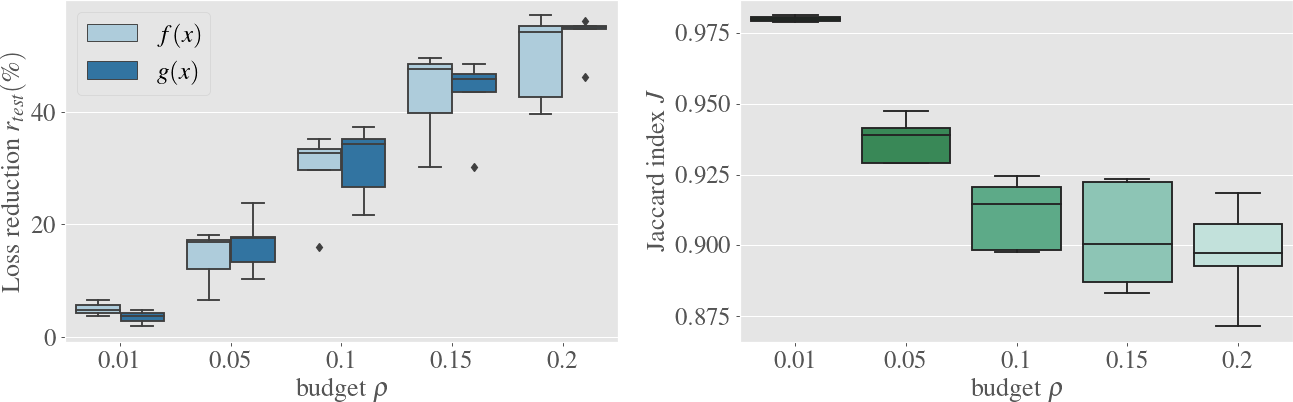

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax[0], palette=pal)
ax[0].set_xlabel(r'budget $\rho$')
ax[0].set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax[0].legend(loc='upper left')
pal = sns.color_palette('BuGn_r')
sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
ax[1].set_xlabel(r'budget $\rho$')
ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fxgx = "drive/My Drive/NIPS2020/results/physionetchallenge2012/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx, bbox_inches='tight', facecolor='w')

In [ ]:
report_table_concat = pd.concat(report_table)
table_by_row_index = report_table_concat.groupby(report_table_concat.index)
report_table_mean = table_by_row_index.mean()
report_table_std = table_by_row_index.std()

report_criteria_concat = pd.concat(report_criteria)
table_by_row_index = report_criteria_concat.groupby(report_criteria_concat.index)
report_criteria_mean = table_by_row_index.mean()
report_criteria_std = table_by_row_index.std()

In [ ]:
report_table_mean

In [ ]:
report_criteria_mean

In [ ]:
output = io.StringIO()
columns = ['%reduction_val','budget','%reduction_test']
df1=report_table_mean[columns]
df2=report_table_std[columns]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df2.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row = [r"{:.2f}$\pm${:.2f}".format(val1,val2) if pval[i]<=0.05 else r"{}" for val1, val2 in zip(df1.iloc[i], df2.iloc[i])]
  output.write("{{}} & {{}} & {rho} & %s & {H0} \\\\\n".format(rho=rho[i],H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$') % (" & ".join(row)))
print(output.getvalue())

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


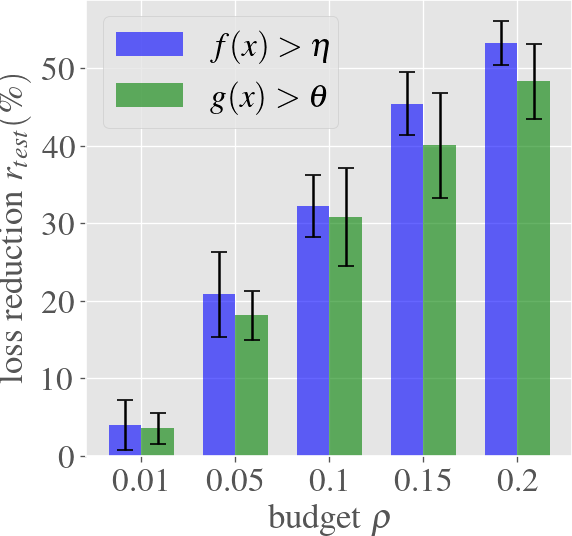

In [ ]:
# data to plot
means_table = report_table_mean['%reduction_test'].to_numpy()
std_table = report_table_std['%reduction_test'].to_numpy()
means_crit = report_criteria_mean['%reduction_test'].to_numpy()
std_crit = report_criteria_std['%reduction_test'].to_numpy()
n_groups = means_table.size

# create plot
fig, ax = plt.subplots(figsize=(5.4, 5.1), constrained_layout=False, dpi=120)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = plt.bar(index, means_table, bar_width, yerr=std_table, capsize=5,
alpha=opacity, color='b', label=r'$f(x)>\eta$')

rects2 = plt.bar(index + bar_width, means_crit, bar_width, yerr=std_crit, capsize=5,
alpha=opacity, color='g', label=r'$g(x)>\theta$')

plt.xlabel(r'budget $\rho$')
plt.ylabel(r'loss reduction $r_{test}(\%)$')
# plt.title('Scores by person')
plt.xticks(index + bar_width/2, (['{}'.format(i) for i in report_table_mean['rho_user'].to_numpy()]))
plt.legend()

plt.tight_layout()
plt.show()